# Final Presentation for the Transformers team



In [1]:
from src.power_system_simulation.graph_processor import GraphProcessor

## Graph Processing
In Graph Processing we are building a simple graph processing class. We build an undirected graph and implement two functionalties:

- Find downstream vertices
- Find alternative edges

## Making a graph

- A class for processing undirected graphs.  
- This class provides functionalities: initializing a graph, finding downstream vertices of an edge, and identifying alternative edges for ensuring graph connectivity.

### Attributes:
- **graph**: A NetworkX graph representing the processed graph.


### Arguments
- `vertex_ids` (List[int]): List of vertex IDs.
- `edge_ids` (List[int]): List of edge IDs.
- `edge_vertex_id_pairs` (List[Tuple[int, int]]): List of tuples - - representing vertex pairs for each edge.
- `edge_enabled` (List[bool]): List indicating whether each edge is either enabled (true) or disabled (false) 
- `source_vertex_id` (int): ID of the source vertex.


## Module structure

The module `model_processor` is made out of 5 functions:
1. `load_input_data`  
    Reads the data from the three files and checks that it is correct.
   **Inputs**:  
   - `active_data_path` (str): Path to active power data (parquet)  
   - `reactive_data_path` (str): Path to reactive power data (parquet)  
   - `model_data_path` (str): Path to static network model (JSON)  
   **Outputs**:  
   - `active_df` (DataFrame), `reactive_df` (DataFrame), `dataset` (dict)

2. `run_updated_power_flow_analysis`  
    Takes the data that was read from `load_input_data` and performs a PGM batch update.
   **Inputs**:  
   - `active_df` (DataFrame): Active power values indexed by time  
   - `reactive_df` (DataFrame): Reactive power values indexed by time  
   - `dataset` (dict): Static model of the power grid  
   **Output**:  
   - `output` (dict): Power flow simulation results

3. `node_voltage_summary`  
    Takes as input the model from `run_updated_power_flow_analysis`. Aggregates voltage results and creates a dataframe for them.
   **Inputs**:  
   - `output` (dict): Simulation output  
   - `timestamps` (Index): Time index from the input data  
   **Output**:  
   - `node_df` (DataFrame): Voltage stats per timestamp and node

4. `line_statistics_summary`  
   Takes as input the model from `run_updated_power_flow_analysis`. Aggregates line results and creates a dataframe for them/
   **Inputs**:  
   - `output` (dict): Simulation output  
   - `timestamps` (Index): Time index from the input data  
   **Output**:  
   - `line_df` (DataFrame): Energy loss and loading stats per line

5. `data_processing`  
   Uses all the functions in order and returns both dataframes. 
   **Inputs**:  
   - `active_data_path`, `reactive_data_path`, `model_data_path` (str): Input file paths  
   **Outputs**:  
   - `node_df`, `line_df` (DataFrames): Summaries of node voltages and line metrics

### Raises

- **`IDNotUniqueError`**  
  Raised if there are duplicate vertex or edge IDs.

- **`InputLengthDoesNotMatchError`**  
  Raised if the length of `edge_enabled` does not match the lengths of the input lists `edge_ids`.

- **`IDNotFoundError`**  
  Raised if a vertex ID in `edge_vertex_id_pairs` does not exist in `vertex_ids`.

- **`GraphNotFullyConnectedError`**  
  Raised if the graph is not fully connected.

- **`GraphCycleError`**  
  Raised if the graph contains one or more cycles.


The functionalities of this class can be tested through a grid, which is created by using the code below: 

In [2]:
from src.power_system_simulation.graph_processor import GraphProcessor

vertex_ids = [0, 2, 4, 6, 10]
edge_ids = [1, 3, 5, 7, 8, 9]
edge_vertex_id_pairs = [(0, 2), (0, 4), (0, 6), (2, 4), (4, 6), (2, 10)]
edge_enabled = [True, True, True, False, False, True]
source_vertex_id = 10

grid = GraphProcessor(vertex_ids, edge_ids, edge_vertex_id_pairs, edge_enabled, source_vertex_id)

### Graph depiction 
The graph created above can be visualized in the following way:

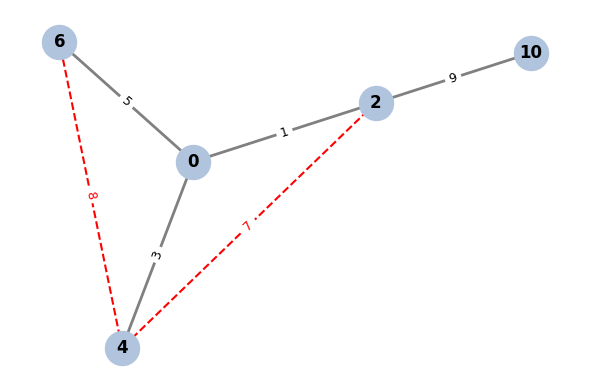

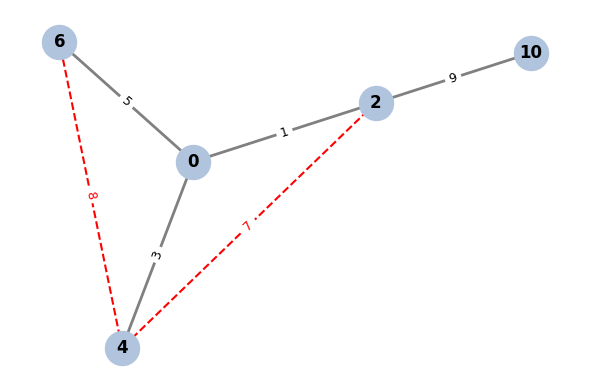

In [3]:
grid.get_figure()

### Finding downstream vertices 

**Arguments:**
- `starting_edge_id (int)`: ID of the edge to find downstream vertices for.

**Returns:**
- `List[int]`: List of vertex IDs downstream from the specified edge.

**Method:**
1. **Check edge existence**:
   - Raise an exception if the ID is not in the edge list.

2. **Check if the edge is enabled**:
   - If disabled, there's no downstream effect → return empty list.

3. **Get the edge’s vertex pair**:
   - Use `edge_vertex_id_pairs` to get `(vertex1, vertex2)`.

4. **Simulate edge removal**:
   - Copy the graph to avoid modifying the original.
   - Remove the given edge from the copied graph.

5. **Compute connected components**:
   - Use NetworkX to find components after edge removal.

6. **Find source-containing component**:
   - Identify the group containing `source_vertex_id`.

7. **Return the disconnected part**:
   - Return the other component (not containing the source).
   - If no separation occurred, return an empty list.

In [4]:
downstream_vertices1 = grid.find_downstream_vertices(1) 
downstream_vertices1

[0, 4, 6]

### Finding alternative edges 

Find alternative disabled edges that, if re-enabled, can restore full connectivity to the graph without introducing a cycle — after a specific edge is disabled.

### Arguments:
- `disabled_edge_id (int)`: ID of the edge that is about to be disabled.

### Returns:
- `List[int]`: List of edge IDs that could be re-enabled as alternatives to restore full graph connectivity without forming a cycle.



   

### Method:

1. **Validate the input edge**:
   - If the given edge ID doesn't exist, raise `IDNotFoundError`.
   - If the edge is already disabled, raise `EdgeAlreadyDisabledError`.

2. **Find all currently disabled edges**:
   - Loop through `edge_enabled` and collect IDs of disabled edges.

3. **Prepare a baseline edge status map**:
   - Copy the current state of all edges.
   - Mark the given `disabled_edge_id` as `False` (simulate disabling it).

4. **Test each disabled edge**:
   - For each `test_edge_id` in the disabled list:
     - Temporarily enable just that edge in a new status map.
     - Reconstruct the graph using this temporary configuration.

5. **Check the test graph**:
   - If the resulting graph is **connected** AND **does not form a cycle**, then it's a valid alternative.

6. **Add valid alternatives to the list**:
   - If both conditions are met, add `test_edge_id` to `alt_list`.

7. **Return the list** of alternative edge IDs.


In [5]:
alternative_edges = grid.find_alternative_edges(3)
alternative_edges

[7, 8]

# Model Processor

Using the `GraphProcessor` class a model can be created and analyzed using `model_processor`.

### Module structure and working principle

The module `model_processor` is made out of 5 functions:
1. `load_input_data`  
    Reads the data from the three files and checks that it is correct.
   **Inputs**:  
   - `active_data_path` (str): Path to active power data (parquet)  
   - `reactive_data_path` (str): Path to reactive power data (parquet)  
   - `model_data_path` (str): Path to static network model (JSON)  
   **Outputs**:  
   - `active_df` (DataFrame), `reactive_df` (DataFrame), `dataset` (dict)

2. `run_updated_power_flow_analysis`  
    Takes the data that was read from `load_input_data` and performs a PGM batch update.
   **Inputs**:  
   - `active_df` (DataFrame): Active power values indexed by time  
   - `reactive_df` (DataFrame): Reactive power values indexed by time  
   - `dataset` (dict): Static model of the power grid  
   **Output**:  
   - `output` (dict): Power flow simulation results

3. `node_voltage_summary`  
    Takes as input the model from `run_updated_power_flow_analysis`. Aggregates voltage results and creates a dataframe for them.
   **Inputs**:  
   - `output` (dict): Simulation output  
   - `timestamps` (Index): Time index from the input data  
   **Output**:  
   - `node_df` (DataFrame): Voltage stats per timestamp and node

4. `line_statistics_summary` 
   Takes as input the model from `run_updated_power_flow_analysis`. Aggregates line results and creates a dataframe for them/
   **Inputs**:  
   - `output` (dict): Simulation output  
   - `timestamps` (Index): Time index from the input data  
   **Output**:  
   - `line_df` (DataFrame): Energy loss and loading stats per line

5. `data_processing`  
   Uses all the functions in order and returns both dataframes. 
   **Inputs**:  
   - `active_data_path`, `reactive_data_path`, `model_data_path` (str): Input file paths  
   **Outputs**:  
   - `node_df`, `line_df` (DataFrames): Summaries of node voltages and line metrics

### Finding an optimal tap position
 Finding the optimal tap position of the transformer based on one of the following criteria:
- The minimal total energy loss of all the lines and the whole time period.
- The minimal (averaged across all nodes) deviation of (max and min) p.u. node voltages with respect to 1 p.u.


###  Arguments

- **`input_network_data`** (`.json`):  
  JSON file describing the electrical network topology and components.

- **`active_power_profile_path`** (`.parquet`):  
  File path to the active power profile dataset.

- **`reactive_power_profile_path`** (`.parquet`):  
  File path to the reactive power profile dataset.

- **`optimize_by`** (`int`):  
  Optimization objective:
  - `0`: Minimize power losses  
  - `1`: Minimize voltage deviation


### Implementation

Importing requirments and adding the paths for all the data.

In [6]:
from pathlib import Path
from src.power_system_simulation.model_processor import data_processing


In [ ]:
BASE_DIR_BIG_DATA = Path.cwd() / "data" / "big_network/input" 

INPUT_DATA_PATH_BIG_DATA = BASE_DIR_BIG_DATA / "input_network_data.json"
ACTIVE_DATA_PATH_BIG_DATA = BASE_DIR_BIG_DATA / "active_power_profile.parquet"
REACTIVE_DATA_PATH_BIG_DATA = BASE_DIR_BIG_DATA / "reactive_power_profile.parquet"
METADATA_PATH_BIG_DATA = BASE_DIR_BIG_DATA / "meta_data.json"
EV_ACTIVE_PATH_BIG_DATA = BASE_DIR_BIG_DATA / "ev_active_power_profile.parquet"


### Big network
Execute the update and get the dataframes for the node and line statistics.

In [8]:
node_df, line_df  = data_processing(ACTIVE_DATA_PATH_BIG_DATA,REACTIVE_DATA_PATH_BIG_DATA, INPUT_DATA_PATH_BIG_DATA )

In [9]:
node_df

,Max_Voltage,Max_Voltage_Node,Min_Voltage,Min_Voltage_Node
Timestamp,,,,
2025-01-01 00:00:00,1.074658,1,1.049898,0
2025-01-01 00:15:00,1.074532,1,1.049891,0
2025-01-01 00:30:00,1.074927,1,1.049916,0
2025-01-01 00:45:00,1.074601,1,1.049894,0
2025-01-01 01:00:00,1.074482,1,1.049885,0
...,...,...,...,...
2025-12-31 22:45:00,1.070302,1,1.049715,0
2025-12-31 23:00:00,1.070859,1,1.049746,0
2025-12-31 23:15:00,1.070879,1,1.049734,0


# Power System Simulation

This module covers the implementation of several class models and functions in order to simulate a LV grid.

These ensure a valid input configuration is provided by the user (`ValidatePowerSystemSimulation`), they simulate the effect of electrical vehicle (EV) penetration on the grid, they simulate the transformer optimize its tap positions based on power flow calculations performed with the `model_processor` function, as well as provide the user with an alternative grid topology when a given line is out of service.

## Validity check
### `validity_check()`

This module ensures a valid input configuration is provided by the user.

The function takes all the provided files as string inputs and reads them for further analysis.

   **Input**:  
   - `input_network_data` (str): Path to input network data (JSON)
   - `meta_data_str` (str): Path to meta data (JSON)
   - `ev_active_power_profile` (str): Path to active power profile data per EV (parquet)  
   - `active_power_profile` (str): Path to active power load profile data (parquet)  
   - `reactive_power_profile` (str): Path to reactive power load profile data (parquet)  

### Working principle
Checks are performed to ensure proper input configuration. If the provided data does not correspond to the expected data, the following exceptions can be issued:
1. `TooManyTransformers`: The network only allows for one transformer present in the grid
2. `TooManySources`: The network only allows for one source present in the grid
3. `TransformerAndFeedersNotConnected`: The transformer has to be connected to the LV Feeders
4. `TimestampsDoNotMatchError`: The timestamps in the provided data for all powers have to match
5. `NotAllFeederIDsareValid`: The provided feeder IDs have to be valid line IDs in the network
6. `TooFewEVs`: The number of EV charging profiles has to be at least equal to the number of houses in the grid

## Electric Vehicle Penetration simulation
### `ev_penetration()`

Simulates the effect of adding electric vehicle (EV) charging loads to a power distribution network.

The function randomly assigns EV chargers to a specified percentage of households (sym_loads), distributes them evenly across LV feeders, and computes the resulting impact on network, computing the power flow calculation. 

 **Inputs**

- `input_network_data` (str): Path to the JSON file describing the static power grid.
- `meta_data_str` (str): Path to the JSON metadata describing LV feeders and the LV busbar.
- `active_power_profile_path` (str): Path to the parquet file with household base load profiles.
- `ev_active_power_profile` (str): Path to the parquet file containing EV charging profiles.
- `percentage` (float): Target percentage of houses to receive EV chargers.
- `seed` (int): Random seed for reproducible charger placement.

 **Outputs**

Returns a tuple of two `DataFrame` objects:
- `voltage_df`: Summary of node voltages per time step.
- `line_df`: Summary of line-level power losses and loading.

### Working principle

1. Load network, metadata, and power profiles.
2. Build a graph from the grid using `GraphProcessor`.
3. Assign EV chargers to households randomly but evenly across feeders, making sure that a profile does not repeat.
4. Add EV charging loads to the base active power profile.
5. Run a power flow analysis with the updated demand.
6. Summarize node and line performance using 4. `line_statistics_summary` and `node_voltage_summary`.


### Implementation

In [10]:
from src.power_system_simulation import ev_penetration_module as EV

node_df, line_df = EV.ev_penetration(INPUT_DATA_PATH_BIG_DATA, METADATA_PATH_BIG_DATA, ACTIVE_DATA_PATH_BIG_DATA, EV_ACTIVE_PATH_BIG_DATA, 50, 10)
node_df

,Max_Voltage,Max_Voltage_Node,Min_Voltage,Min_Voltage_Node
Timestamp,,,,
2025-01-01 00:00:00,1.075613,1,1.049934,0
2025-01-01 00:15:00,1.075664,1,1.049936,0
2025-01-01 00:30:00,1.075645,1,1.049935,0
2025-01-01 00:45:00,1.075614,1,1.049934,0
2025-01-01 01:00:00,1.075543,1,1.049931,0
...,...,...,...,...
2025-12-31 22:45:00,1.073118,1,1.049836,0
2025-12-31 23:00:00,1.072648,1,1.049817,0
2025-12-31 23:15:00,1.073391,1,1.049848,0


In [11]:
line_df

,Total_Loss,Max_Loading,Max_Loading_Timestamp,Min_Loading,Min_Loading_Timestamp
Line_ID,,,,,
1204,74.745735,5.651776e-02,2025-12-26 21:30:00,1.543673e-03,2025-08-13 09:15:00
1205,1.734047,2.027467e-02,2025-04-06 16:30:00,4.211856e-07,2025-02-02 08:15:00
1206,73.576510,5.229503e-02,2025-12-26 21:30:00,1.058467e-03,2025-10-13 00:45:00
1207,0.038607,4.215723e-07,2025-01-08 03:00:00,4.191103e-07,2025-12-26 21:45:00
1208,70.529950,5.455391e-02,2025-12-26 21:30:00,1.104174e-03,2025-10-13 00:45:00
...,...,...,...,...,...
2006,0.032271,2.447747e-07,2025-08-16 04:30:00,2.403347e-07,2025-07-21 17:00:00
2007,0.031886,2.447851e-07,2025-04-26 07:45:00,2.400023e-07,2025-12-31 15:15:00
2008,0.037685,2.447719e-07,2025-11-27 15:15:00,2.406148e-07,2025-04-21 22:15:00


## Optimal tap simulation

### `optimal_tap_position()`

 The function simulates the transformer optimizing its tap positions based on power flow calculations performed with the `model_processor` function.

 It takes as input the provided files for the input data and the active and reactive power profiles. Moreover, it takes as input the optimization mode to be selected by the user.

   **Input**:  
   - `input_network_data` (str):  Path to input network data (JSON)
   - `active_power_profile_path` (str): Path to active power load profile data (parquet) 
   - `reactive_power_profile_path` (str): Path to reactive power load profile data (parquet)  
   - `optimize_by` (int): Option `0` represents optimizing by minimal total energy loss of all the lines; option `1` represents optimizing by minimal voltage deviation of node voltages with respect to 1 p.u.
    
It then determines the optimal tap positions for both situtations, and outputs the one demanded by the user.

   **Output**:  
   - `total_losses_min_tap_pos` (int): Optimal tap position for minimal total energy loss
   - `average_dev_min_tap_pos` (int): Optimal tap position for minimal voltage deviation

### Working principle

1. Load network and active and reactive power profiles, as well as optimization method selected by the user.
2. Identify the minimum and maximum possible tap positions of the transformer.
3. Navigate through all possible tap positions.
4. Identify the optimal tap position for minimal total energy loss.
5. Identify the optimal tap position for minimal voltage deviation of node voltages.
6. Return the optimal tap position for the optimization mode chosen by the user.

### Implementation

In [12]:
from pathlib import Path
from power_system_simulation.optimal_tap import optimal_tap_position


In [13]:
optimize_by0 = 0
optimize_by1 = 1

In [14]:
tap = optimal_tap_position(INPUT_DATA_PATH_BIG_DATA, ACTIVE_DATA_PATH_BIG_DATA, REACTIVE_DATA_PATH_BIG_DATA, optimize_by0)
tap

1

In [15]:
tap = optimal_tap_position(INPUT_DATA_PATH_BIG_DATA, ACTIVE_DATA_PATH_BIG_DATA, REACTIVE_DATA_PATH_BIG_DATA, optimize_by1)
tap

3

## N-1 calculations
Analyzes the grid when a given line is out of service. 
### `nm_function`

This function simulates the behaviur of the grid by assessing the effect of disconnecting a single line in the network and evaluating alternative line configurations.

###  **Inputs**

- `given_lineid` (int): The ID of the line to be disconnected for testing.
- `input_data_path` (str): Path to the JSON file representing the static power grid.
- `metadata_path` (str): Path to metadata file describing LV structure (e.g., transformer connections).
- `active_power_profile_path` (str): Path to the CSV file containing time-series active power data.
- `reactive_power_profile_path` (str): Path to the CSV file containing time-series reactive power data.

### **Output**

Returns a `DataFrame` with the following columns:

- `Alternative ID`: The line ID that was enabled as a substitute.
- `Max Loading`: The maximum observed loading across all lines during the simulation.
- `ID_max`: The ID of the line where max loading occurred.
- `Timestamp_max`: The timestamp corresponding to the max loading.


### Working principle 

1. **Load grid model and time-series data** using the `model_processor`.
2. **Build the network graph** using `GraphProcessor`, including transformers and feeders.
3. **Validate the input line ID**:
   - Must be an `int`
   - Must exist in the network
   - Must be enabled on both ends
4. **Find valid alternative lines** for replacement using `GraphProcessor`.
5. **Simulate each alternative configuration** and evaluate performance using `model_processor`.
6. **Return performance summary** with max line loading and timestamp.


### Implementation

In [21]:
from src.power_system_simulation import n1_calculation as EV
EV.nm_function(1892, INPUT_DATA_PATH_BIG_DATA, METADATA_PATH_BIG_DATA, ACTIVE_DATA_PATH_BIG_DATA, REACTIVE_DATA_PATH_BIG_DATA)

,Alternative ID,Max Loading,ID_max,Timestamp_max
0,2009,0.073651,1714,2024-11-04 23:15:00
1,2010,0.079666,1906,2024-11-04 18:15:00
